In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import itertools
import numpy as np
from random import seed

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

I have gathered a dataset from citydata. Over the course of several days I respectfully scraped information about each county in the United States, creating the following data set:

In [40]:
df = pd.read_csv('df_citydata.csv')

In [41]:
df.head()

,fips,state,county,pop_in_later_year,pop_ref_later_year,pop_f,pop_m,pop_in_2000,median_age,median_age_f,...,births_to_yr_int2,pop_foreign_born,land_area_km2,land_area_mi2,water_area_km2,water_area_mi2,total_area_km2,total_area_mi2,latitude,longitude
0,1001,AL,Autauga,55308.0,2017,28306.0,27002.0,43671.0,38.0,39.2,...,2006.0,1170.0,1539.582,594.436,25.776,9.952,1565.358,604.388,32.536382,-86.644490
1,1003,AL,Baldwin,212628.0,2017,107930.0,104698.0,140415.0,42.6,44.3,...,2006.0,10881.0,4117.522,1589.784,1133.190,437.527,5250.712,2027.311,30.659218,-87.746067
2,1005,AL,Barbour,26330.0,2017,12301.0,14029.0,29038.0,39.9,43.3,...,2006.0,701.0,2291.819,884.876,50.865,19.639,2342.684,904.515,31.870670,-85.405456
3,1007,AL,Bibb,22691.0,2017,10393.0,12298.0,20826.0,40.0,43.6,...,2006.0,232.0,1612.481,622.582,9.289,3.587,1621.770,626.169,33.015893,-87.127148
4,1009,AL,Blount,57952.0,2017,29352.0,28600.0,51024.0,41.1,42.6,...,2006.0,2638.0,1669.962,644.776,15.157,5.852,1685.119,650.628,33.977448,-86.567246


Here are the column names. Most of the names should be self explanatory. Please see the accompanying data dictionary for an explanation of each variable.

In [42]:
df.columns

Index(['fips', 'state', 'county', 'pop_in_later_year', 'pop_ref_later_year',
       'pop_f', 'pop_m', 'pop_in_2000', 'median_age', 'median_age_f',
       'median_age_m', 'median_house_income_2017',
       'median_house_income_ref_val', 'median_house_income_ref_yr',
       'median_house_value_2017', 'median_house_value_2000',
       'avg_household_size', 'mar_coup_w_children', 'cost_of_living_usd',
       'cost_of_living_yr', 'poverty_pct', 'adult_obes_rate',
       'presch_obes_rate', 'commute_minutes', 'pop_per_sq_mi',
       'pop_percent_urban', 'unemploy_rate', 'unemploy_date', 'rent_1br_usd',
       'rent_2br_usd', 'rent_3br_usd', 'avg_farm_size', 'avg_farm_sales_usd',
       'pct_farms_fam_op', 'avg_farm_mach_val_usd', 'birth_per_1000_int1',
       'births_from_yr_int1', 'births_from_yr_int2', 'birth_per_1000_int2',
       'births_to_yr_int1', 'births_to_yr_int2', 'pop_foreign_born',
       'land_area_km2', 'land_area_mi2', 'water_area_km2', 'water_area_mi2',
       'total_area_km

Now I'll compute the target variable: the appreciation rate of the median house value between the years 2000 and 2017.

In [43]:
df['house_appreciation_pct']=(df.median_house_value_2017/df.median_house_value_2000)**(1/17)
df['house_appreciation_pct']

0       1.036983
1       1.038395
2       1.030623
3       1.040565
4       1.031697
          ...   
3139    1.051335
3140    1.051335
3141    1.051335
3142    1.051335
3143    1.051335
Name: house_appreciation_pct, Length: 3144, dtype: float64

The fact that the last five entries are identical is alarming. The precision is too great for this to be a coincidence. Looking closer, I noticed that the appreciation for Wyoming is computed, not measured as purported. Shame on you, citydata. I investigate the extent to which this important target variable is inorganic by virtue of being computed (presumably based on a statewide average).

/home/chris/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/chris/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


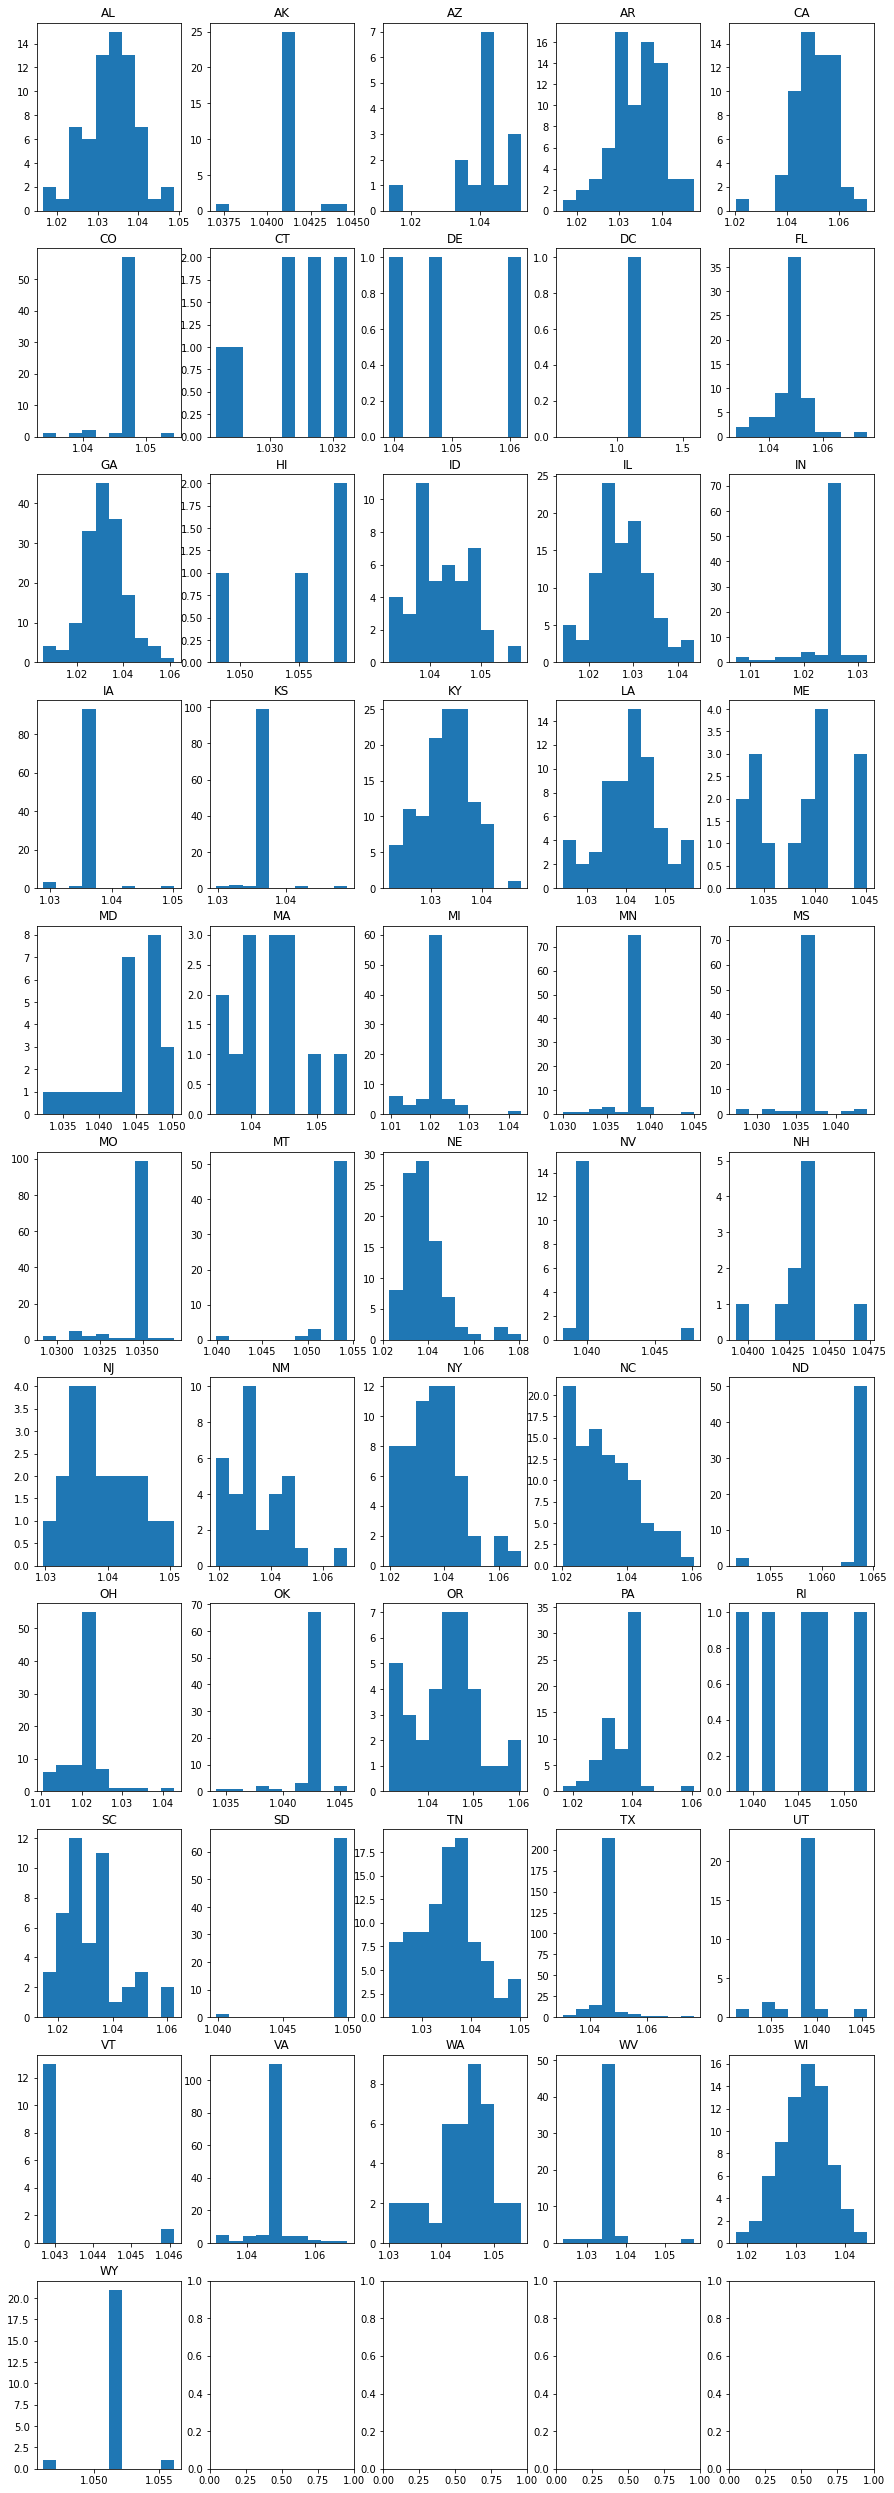

In [44]:
fig, axs = plt.subplots(11,5,figsize=(15, 45))
states = df.state.unique()
index = 0
for pair in itertools.product(*[range(11),range(5)]):
    vals=df[df.state==states[index]]['house_appreciation_pct']
    axs[pair].hist(vals)
    axs[pair].title.set_text(states[index])
    index+=1
    if index==51: break

The following states appear to have computed their home values based on presumed appreciation in at least some of the counties: AK, CO, FL, IN, IA, KS, MN, MS, MO, MT, NV, ND, OK, SD, TX, UT, VT, VA, WV, WY. To cure the data, I will take the following action. I will identify the states in which an improbably high proportion of the counties have the mode home appreciation rate. In these states, the counties having the state mode appreciation rate will be presumed to be computed, and will therefore be discounted from the analysis.

In [45]:
def get_mode(state):
    ''' accepts: a state abbreviation
        returns: the mode house appreciation value
    '''
    x=df[df.state==state].house_appreciation_pct
    return(stats.mode(x)[0][0])

def get_mode_ratio(state):
    ''' accepts: a state abbreviation
        returns: the ratio of the counties in the state presumed to have computed average
                 home values by virtue of having appreciated at the mode level
    '''
    state_len = len(df[df.state==state])
    mode = get_mode(state)
    mode_len = len(df[(df.state==state)&(df.house_appreciation_pct==mode)])
    ratio = mode_len/state_len
    return(ratio)

Five decimal places is enough accuracy for the appreciation rate, and rounding to five decimal places will uncomplicate the procedure of locating computed rates. So I round.

In [46]:
df.house_appreciation_pct=round(df.house_appreciation_pct,5)

Now I'll plot a histogram for the following metric: the percentage of counties in each state having the mode appreciation rate. The maximum value is 1; a state with a value of 1 has identical reported appreciation rates in every county. The minimum is $1/N$ where $N$ is the number of counties in the state; this happens when all counties in the state have unique appreciation rates. So the goal of this visual is to draw a line separating states likely to have computed county home values (on the right of the line) from states likely to have measured the values in each county (on the left of the line).

(array([19.,  4.,  0.,  7.,  1.,  0.,  1.,  4., 10.,  5.]),
 array([0.01 , 0.109, 0.208, 0.307, 0.406, 0.505, 0.604, 0.703, 0.802,
        0.901, 1.   ]),
 <BarContainer object of 10 artists>)

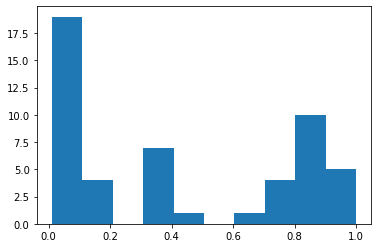

In [47]:
ratios = []
for state in states:
     ratios.append(get_mode_ratio(state))
plt.hist(ratios)

I judge that 0.25 separates the states with computed values from the others.

In [48]:
# Create a list of states which computed some average home values in some counties
naughty_states=[]
for state in states:
    if get_mode_ratio(state)>0.25:
        naughty_states.append(state)
print('States with computed home values: {}'.format(', '.join(naughty_states)))

States with computed home values: AK, AZ, CO, DE, DC, FL, IN, IA, KS, MD, MI, MN, MS, MO, MT, NV, NH, ND, OH, OK, PA, SD, TX, UT, VT, VA, WV, WY


Now to exclude the counties with computed average home values. I will create a row function which returns True if the row's average home value is not computed, and False if it is. Then I can use the function to drop the appropriate rows.

In [49]:
def is_not_computed(row):
    # accepts: a row from the citydata dataframe
    # returns: True if the row does not have a computed average home value
    mode = get_mode(row.state)
    if state in naughty_states and row.house_appreciation_pct==mode:
        return(False)
    else:
        return(True)

In [50]:
df = df[df.apply(is_not_computed,axis=1)]

In [51]:
len(df)

1764

We still have 1764 observations.

I'll derive some new variables that I think will be relevant. For example, I don't think population in the reference year (2000) and population in the later year (between 2005 and 2017) will be as relevant as the average population percentage growth between the two years.

In [52]:
df['pop_growth_rate']=(df.pop_in_later_year-df.pop_in_2000)**(1/(df.pop_ref_later_year-2000))

I'll also derive the population density (population over land area), urban population density (urban population over land area), median age difference between males and females, average annual percentage change in household income, the fraction of the population consisting of married couples with children, the adult obesity rate over the poverty rate, the commute time over the square root of the land area, the cost of a 3 bedroom apartment divided by the cost of a 1 bedroom apartment, the change in birthrate from the 1990-2000 period to the 2000-2006 period, and the foreign born population as a percentage of the total population.

In [53]:
df['pop_density']=df.pop_in_later_year/df.land_area_mi2
df['urban_pop_density']=df.pop_density*df.pop_percent_urban
df['gender_age_gap']=df.median_age_m - df.median_age_f
df['income_growth_rate']=(df.median_house_income_2017-df.median_house_income_ref_val)**\
                      (1/(2017-df.median_house_income_ref_yr))
df['married_with_kids_ratio']=df.mar_coup_w_children*2/df.pop_in_later_year
df['commute_over_sqrt_area']=df.commute_minutes/np.sqrt(df.land_area_mi2)
df['apartment_rent_ratio']=df.rent_3br_usd/df.rent_1br_usd
df['birth_rate_change']=df.birth_per_1000_int2 - df.birth_per_1000_int1
df['foreign_born_pct'] = df.pop_foreign_born/df.pop_in_later_year

I'll check the correlation matrix for interesting variables. I'll drop the columns not otherwise in use, then drop the rows with missing values.

In [54]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

/home/chris/.local/lib/python3.6/site-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/home/chris/.local/lib/python3.6/site-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


In [55]:
keep = ['median_house_income_2017','median_house_value_2017','cost_of_living_usd','adult_obes_rate',
        'rent_3br_usd','pct_farms_fam_op','pop_growth_rate','income_growth_rate','foreign_born_pct',
        'longitude','house_appreciation_pct']
df=df[keep]

I drop the rows with nan values in the remaining columns.

In [56]:
df=df.dropna()

In [57]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,median_house_income_2017,median_house_value_2017,cost_of_living_usd,adult_obes_rate,rent_3br_usd,pct_farms_fam_op,pop_growth_rate,income_growth_rate,foreign_born_pct,longitude,house_appreciation_pct
median_house_income_2017,1.000000,0.731350,0.694337,-0.498599,0.758952,-0.252503,0.530269,0.787164,0.447576,-0.022051,0.244431
median_house_value_2017,0.731350,1.000000,0.746712,-0.666931,0.844924,-0.430595,0.482364,0.589811,0.626718,-0.301788,0.505166
cost_of_living_usd,0.694337,0.746712,1.000000,-0.484562,0.816691,-0.424279,0.448313,0.498544,0.578795,0.035586,0.320891
adult_obes_rate,-0.498599,-0.666931,-0.484562,1.000000,-0.595600,0.356768,-0.397407,-0.418665,-0.486440,0.258341,-0.386926
rent_3br_usd,0.758952,0.844924,0.816691,-0.595600,1.000000,-0.440879,0.554804,0.548748,0.643280,-0.179517,0.354377
pct_farms_fam_op,-0.252503,-0.430595,-0.424279,0.356768,-0.440879,1.000000,-0.217651,-0.211068,-0.577279,0.065840,-0.242591
pop_growth_rate,0.530269,0.482364,0.448313,-0.397407,0.554804,-0.217651,1.000000,0.371908,0.545591,-0.060173,0.277120
income_growth_rate,0.787164,0.589811,0.498544,-0.418665,0.548748,-0.211068,0.371908,1.000000,0.323295,-0.137958,0.446210
foreign_born_pct,0.447576,0.626718,0.578795,-0.486440,0.643280,-0.577279,0.545591,0.323295,1.000000,-0.188493,0.359569
longitude,-0.022051,-0.301788,0.035586,0.258341,-0.179517,0.065840,-0.060173,-0.137958,-0.188493,1.000000,-0.332685


In [59]:
# Split the dataset into train, validation, and test sets
# set the random seed
seed(1274)

# separate out the features and target
X = df.iloc[:,df.columns != 'house_appreciation_pct']
y = df.iloc[:,df.columns=='house_appreciation_pct']

# train/validation/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# standardize the features
X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)
X_test = StandardScaler().fit_transform(X_test)
y_train = StandardScaler().fit_transform(y_train)
y_val = StandardScaler().fit_transform(y_val)
y_test = StandardScaler().fit_transform(y_test)

I'll fit a variety of models to the training data, then test them on the validation data. I will take the best model and check on on the test data.

Text(0.5, 1.0, 'PCA: features remaining vs variance retained')

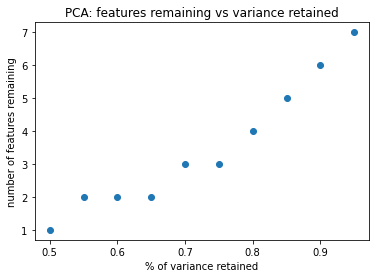

In [60]:
seed(1274)

xs = np.linspace(0.50,0.95,10)
ys = []
for i in xs:
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train)
    ys.append(X_train_pca.shape[1])
plt.scatter(xs, ys)
plt.xlabel('% of variance retained')
plt.ylabel('number of features remaining')
plt.title('PCA: features remaining vs variance retained')

Text(0.5, 1.0, 'Linear regression accuracy vs % variance retained in PCA dimensionality reduction')

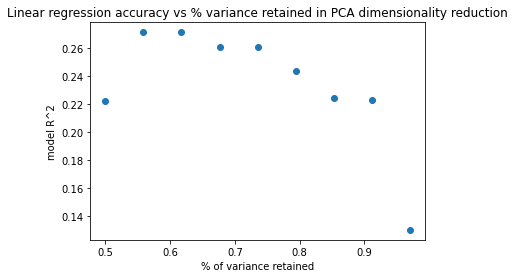

In [25]:
seed(1274)

xs = np.linspace(0.50,0.97,9)
ys = []
for i in xs:
    pca = PCA(n_components=i, whiten = True)
    X_train_pca = pca.fit_transform(X_train)
    ols = LinearRegression()
    ols.fit(X_train_pca, y_train)
    ys.append(ols.score(pca.fit_transform(X_val), y_val))
plt.scatter(xs, ys)
plt.xlabel('% of variance retained')
plt.ylabel('model R^2')
plt.title('Linear regression accuracy vs % variance retained in PCA dimensionality reduction')

In [ ]:
# A dictionary to store the accuracy of each model
accuracy = []

In [26]:
# Trying linear regression. I use PCA to reduce the features.
pca = PCA(n_components=0.65, whiten = True)
X_train_pca = pca.fit_transform(X_train)
ols = LinearRegression()
ols.fit(X_train_pca, y_train)
lin_accuracy = ols.score(pca.fit_transform(X_val), y_val)
print("Linear regression model R^2: {}".format(round(lin_accuracy,3)))
accuracy.append((lin_accuracy,'linear regression',ols))

Linear regression model R^2: 0.271


In [27]:
# Now trying a random forest prediction. First, feature reduction for RF
randomforest = RandomForestRegressor(random_state=1274, n_jobs=-1)
selector = SelectFromModel(randomforest, threshold = 0.001)
X_train_rf = selector.fit_transform(X_train, y_train.ravel())

In [28]:
# train the random forest model
model_rf = randomforest.fit(X_train_rf, y_train.ravel())

# pare X_val to the features used in the rf model
X_val_rf = pd.DataFrame(X_val).iloc[:,selector.get_support()]

# report accuracy
rf_accuracy = model_rf.score(X_val_rf,y_val)
print("Random forest model R^2: {}".format(round(rf_accuracy,3)))
accuracy.append((rf_accuracy,'random forest',model_rf))

Random forest model R^2: 0.608


In [29]:
''' Use GridSearch to discover the best parameters in a predefined range. Given more machine power/time/benefit
    for optimized results, I would expand the search space.
'''
gsc = GridSearchCV(
        estimator=MLPRegressor(),
        param_grid={
            'max_iter': [400,600,800],
            'hidden_layer_sizes': [(30,30),(40,40),(40,30),(40,40)]
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train.ravel())

best_params = grid_result.best_params_

# define the regressor and set parameters
mlp = MLPRegressor(hidden_layer_sizes = best_params['hidden_layer_sizes'], max_iter = best_params['max_iter'])

# fit the model
mlp.fit(X_train,y_train.ravel())

mlp_accuracy = mlp.score(X_val,y_val)

print("Neural network R^2: {}".format(round(mlp_accuracy,3)))
accuracy.append((mlp_accuracy,'neural network',mlp))

/home/chris/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural network R^2: 0.609


In [30]:
# Trying a support vector regressor
svr = SVR()
svr.fit(X_train,y_train.ravel())
svr_accuracy = svr.score(X_val,y_val)
print("Support vector regressor R^2: {}".format(round(svr_accuracy,3)))
accuracy.append((svr_accuracy,'support vector',svr))

Support vector regressor R^2: 0.662


In [31]:
# Trying XGBoost regressor
xgb = XGBRegressor()
xgb.fit(X_train,y_train)
xgb_accuracy = xgb.score(X_val,y_val)
print("XGBoost regressor R^2: {}".format(round(xgb_accuracy,3)))
accuracy.append((xgb_accuracy,'xgb',xgb))

XGBoost regressor R^2: 0.574


In [32]:
# Bagging with decision trees

# Optimizing the number of regresors
x_dct = [5*i for i in range(1,41)]
y_dct = []
for i in x_dct:
    br = BaggingRegressor(base_estimator=DecisionTreeRegressor(),n_estimators=i, random_state=0)
    br.fit(X_train,y_train.ravel())
    y_dct.append(br.score(X_val,y_val))
plt.scatter(x_dct,y_dct)

# Training with the optimum number of regressors
dt_max_num = x_dct[y_dct.index(max(y_dct))]
print('Max decision tree bagging accuracy at {} estimators.'.format(dt_max_num))
br_dt = BaggingRegressor(base_estimator=DecisionTreeRegressor(),n_estimators=dt_max_num, random_state=0)
br_dt.fit(X_train,y_train.ravel())
dt_bag_score = br_dt.score(X_val,y_val)
print('Decision tree bagging accuracy: {}'.format(round(dt_bag_score,3)))
accuracy.append((dt_bag_score,'bagging: decision tree',br_dtfuturamt))

In [33]:
# Bagging with neural networks

# Optimizing the number of regresors
x_mlp = [5*i for i in range(1,11)]
y_mlp = []
for i in x_mlp:
    br = BaggingRegressor(base_estimator=MLPRegressor(),n_estimators=i, random_state=0)
    br.fit(X_train,y_train.ravel())
    y_mlp.append(br.score(X_val,y_val))
plt.scatter(x_mlp,y_mlp)

# Training with the optimum number of regressors
nn_max_num = x_dct[y_mlp.index(max(y_mlp))]
print('Max NN bagging accuracy at {} estimators.'.format(nn_max_num))
br_nn = BaggingRegressor(base_estimator=MLPRegressor(),n_estimators=nn_max_num, random_state=0)
br_nn.fit(X_train,y_train.ravel())
nn_bag_score = br_nn.score(X_val,y_val)
print('NN bagging accuracy: {}'.format(round(nn_bag_score,3)))
accuracy.append((nn_bag_score,'bagging: neural network',br_nn))

In [ ]:
# Bagging with XGBoost

# Optimizing the number of regresors
x_xgb = [5*i for i in range(1,31)]
y_xgb = []
for i in x_xgb:
    br = BaggingRegressor(base_estimator=XGBRegressor(),n_estimators=i, random_state=0)
    br.fit(X_train,y_train.ravel())
    y_xgb.append(br.score(X_val,y_val))
plt.scatter(x_xgb,y_xgb)

# Training with the optimum number of regressors
xgb_max_num = x_xgb[y_xgb.index(max(y_xgb))]
print('Max XGB bagging accuracy at {} estimators.'.format(xgb_max_num))
br_xgb = BaggingRegressor(base_estimator=XGBRegressor(),n_estimators=xgb_max_num, random_state=0)
br_xgb.fit(X_train,y_train.ravel())
xgb_bag_score = br_xgb.score(X_val,y_val)
print('Bagged decision tree accuracy: {}'.format(round(xgb_bag_score,3)))
accuracy.append((xgb_bag_score,'bagging: xgb',br_xgb))

In [ ]:
# Bagging with support vector regressors

# Optimizing the number of regresors
x_svr = [5*i for i in range(1,31)]
y_svr = []
for i in x_svr:
    br = BaggingRegressor(base_estimator=SVR(),n_estimators=i, random_state=0)
    br.fit(X_train,y_train.ravel())
    y_svr.append(br.score(X_val,y_val))
plt.scatter(x_svr,y_svr)

# Training with the optimum number of regressors
svr_max_num = x_svr[y_svr.index(max(y_svr))]
print('Max SVR bagging accuracy at {} estimators.'.format(svr_max_num))
br_svr = BaggingRegressor(base_estimator=SVR(),n_estimators=svr_max_num, random_state=0)
br_svr.fit(X_train,y_train.ravel())
svr_bag_score = br_svr.score(X_val,y_val)
print('Bagged decision tree accuracy: {}'.format(round(svr_bag_score,3)))
accuracy.append((svr_bag_score,'bagging: svr',br_svr))

Let's review the models by accuracy.

In [38]:
accuracy.sort()
print('Accuracy    Model')
print('-'*8,' '*2,'-'*17)
for model in accuracy:
    print('   {}    {}'.format(round(model[0],3),model[1])

Accuracy    Model
--------    -----------------
   0.668    bagging: svr
   0.662    support vector
   0.652    bagging: xgb
   0.609    neural network
   0.608    random forest
   0.574    xgb
   0.271    linear regression


The most accurate model was the bagging neural networks. To check the model's accuracy on unseen data, we now run it on the yet-unseen test data set.

In [1]:
print('Best model: {}'.format(accuracy[0][1]))
best_model = accuracy[0][2]
best_accuracy = best_model.score(X_test,y_test)
print('Accuracy on test data: {}'.format(best_accuracy))